In [75]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

poison_dataset = pd.read_csv("../../poison/generated-5000.csv")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)
poison_dataset.dropna(axis = 0, inplace=True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))
print("The shape of the testing dataset: " + str(poison_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)
The shape of the testing dataset: (5000, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [76]:
# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [77]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

output_poisoning = []
for i, val in enumerate(poison_dataset.iloc[:,-1]):
    temp = [0, 0, 0]
    temp[int(val) - 1] = 1
    output_poisoning.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

prep_poison_dataset = poison_dataset.drop(poison_dataset.columns[-1],axis=1)

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)
# scaler.fit(prep_poison_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

X_poison = scaler.transform(prep_poison_dataset)
Y_poison = np.array(output_poisoning)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))
# print("Preprocessed outputs of the poisoning dataset: " + str(Y_train))

Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the training dataset: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0

In [78]:
'''
This function creates the poisoning values based on poison type
type:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_poison_set(X_train, Y_train, X_poison=None, Y_poison=None, poison_type='new_example', percentage=0, target_bias_class=None):
    X_train_ = X_train.copy().tolist()
    Y_train_ = Y_train.copy().tolist()
    poison_count = -1
    original_count = -1
    if poison_type=='new_example':
        required_samples = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train)
        poison_count = required_samples
        # if len(X_poison)>=required_samples:
        to_copy_idx =[i for i in range(len(X_poison))]
        random.shuffle(to_copy_idx)
        for i in range(required_samples):
            X_train_.append(X_poison[to_copy_idx[i]])
            Y_train_.append(Y_poison[to_copy_idx[i]])
    
    elif poison_type=='existing_example':
        required_samples = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train)
        poison_count = len(X_train) - required_samples
        # if len(X_poison)>=required_samples:
        to_copy_idx =[i for i in range(len(X_poison))]
        flip_idx = random.randint(0,len(X_train_)-1)
        random.shuffle(to_copy_idx)
        for i in range(required_samples):
            X_train[flip_idx] = X_poison[to_copy_idx[i]]
            Y_train[flip_idx] = Y_poison[to_copy_idx[i]]
            
    elif poison_type=='random_swapping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount

        print(len(X_train_)>=flip_amount)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                flip_idx_2 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1], Y_train_[flip_idx_2] = Y_train_[flip_idx_2], Y_train_[flip_idx_1]

    elif poison_type=='targeted_flipping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount
        flip_amount = int(len(X_train_)*percentage*0.01)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1] = target_bias_class
        
        else:
            raise Exception('Poison percentage should not exceed 100 percent')
    else: 
        raise Exception('Cannot recognize poison_type. It should be in one of the followings: new_example, random_swapping, and targeted_flipping')
            
    return np.asarray(X_train_), np.asarray(Y_train_), poison_count, original_count

In [79]:
def impact_metric_spatial(FP, F, is_F1=False):
    if is_F1:
        FP = 1-FP
        F = 1-F
        
    return (FP-F)/F

In [80]:
def complexity_spatial(DP, D):
    return DP/(D + DP)

In [81]:
def evaluate_spatial_metrics_poison_impact(X_test, Y_test, ct_poison, ct_original, model, model_poison, model_type):  
    
    if(model_type=='NN'):
        # evaluating without poisoning 
        _, accuracy_original = model.evaluate(X_test, Y_test)
        # Evaluate the Keras model
        _, accuracy_poisoned = model_poison.evaluate(X_test, Y_test)
        
        # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(Y_test, predictions_original, average="macro")
        f1_poisoned = f1_score(Y_test, predictions_poisoned, average="macro")

    elif(model_type=='xgboost'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(pred_ori,axis=1))
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(pred_poi,axis=1))
        
        # # Make class predictions with the models
        predictions_original = (model.predict(X_test) > 0.5).astype(int)
        predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        f1_original = f1_score(Y_test, predictions_original, average="macro")
        f1_poisoned = f1_score(Y_test, predictions_poisoned, average="macro")
        
        # f1_original = f1_score(np.argmax(Y_test,axis=1), pred_ori, average="macro")
        # f1_poisoned = f1_score(np.argmax(Y_test,axis=1), pred_poi, average="macro")
    
    elif(model_type=='lightgbm'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),pred_ori)
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),pred_poi)
        
        # Make class predictions with the models
        # predictions_original = (model.predict(X_test) > 0.5).astype(int)
        # predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        # f1_original = f1_score(np.argmax(Y_test,axis=1), predictions_original, average="macro")
        # f1_poisoned = f1_score(np.argmax(Y_test,axis=1), predictions_poisoned, average="macro")
        
        f1_original = f1_score(np.argmax(Y_test,axis=1), pred_ori, average="macro")
        f1_poisoned = f1_score(np.argmax(Y_test,axis=1), pred_poi, average="macro")
    
    elif(model_type=='random_forest'):
        pred_ori = model.predict(X_test)
        pred_poi = model_poison.predict(X_test)
        
        accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),pred_ori)
        accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),pred_poi)
        
        # Make class predictions with the models
        # predictions_original = (model.predict(X_test) > 0.5).astype(int)
        # predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

        # f1_original = f1_score(np.argmax(Y_test,axis=1), predictions_original, average="macro")
        # f1_poisoned = f1_score(np.argmax(Y_test,axis=1), predictions_poisoned, average="macro")
        
        f1_original = f1_score(np.argmax(Y_test,axis=1), pred_ori, average="macro")
        f1_poisoned = f1_score(np.argmax(Y_test,axis=1), pred_poi, average="macro")

    # impact metric
    print('accuracy original: %.2f'% (accuracy_original))
    print('accuracy poisoned: %.2f'% (accuracy_poisoned))
    print('f1 original: %.2f'% (f1_original))
    print('f1 poisoned: %.2f'% (f1_poisoned))

    impact = impact_metric_spatial(f1_poisoned, f1_original, is_F1=True)
    complexity = complexity_spatial(ct_poison,ct_original)
    
    return impact, complexity, accuracy_original, accuracy_poisoned, f1_original, f1_poisoned

In [82]:
def get_models_for_attack(model_type, epochs=150, verbose=0):
    if(model_type=='NN'):
        model = Sequential()
        model.add(Dense(12, input_shape=(21,), activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(3, activation='sigmoid'))

        # Compile the Keras model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model_cp = clone_model(model)
        model_cp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, Y_train, epochs=epochs, batch_size=10, verbose=verbose)
        return model, model_cp
    
    elif(model_type=='xgboost'):
        xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
        
        model_cp = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
        xg_reg.fit(X_train,Y_train)
        return xg_reg, model_cp
    
    elif(model_type=='lightgbm'):
        model = ltb.LGBMClassifier()
        model_cp = ltb.LGBMClassifier()
        model.fit(X_train,np.argmax(Y_train,axis=1))
        return model, model_cp
    
    elif(model_type=='random_forest'):
        model = RandomForestClassifier(min_samples_leaf=2, random_state=0)
        model.fit(X_train, np.argmax(Y_train,axis=1))
        model_cp = RandomForestClassifier(min_samples_leaf=2, random_state=0)
        
        return model, model_cp

In [83]:
model_type='random_forest'
model, model_cp = get_models_for_attack(model_type=model_type)
X_train_new, Y_train_new, ct_poison, ct_original = get_poison_set(X_train, Y_train, X_poison, Y_poison, 
                poison_type='new_example', percentage=80,target_bias_class=None)

model_cp.fit(X_train_new, np.argmax(Y_train_new,axis=1))
# model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=True)

impact,complexity,accuracy_original,accuracy_poisoned,_,_ = evaluate_spatial_metrics_poison_impact(X_test=X_test, Y_test=Y_test,  
            ct_poison=ct_poison, ct_original=ct_original, model=model, model_poison=model_cp, model_type=model_type)
print(impact)
print(complexity)

accuracy original: 0.97
accuracy poisoned: 0.98
f1 original: 0.88
f1 poisoned: 0.92
-0.37091503267973763
0.4442231075697211


In [84]:
accuracy_poisoned

0.9805825242718447

In [85]:
accuracy_original

0.970873786407767

In [86]:
model_poison = model_cp
pred_ori = model.predict(X_test)
pred_poi = model_poison.predict(X_test)

accuracy_original = accuracy_score(np.argmax(Y_test,axis=1),pred_ori)
accuracy_poisoned = accuracy_score(np.argmax(Y_test,axis=1),pred_poi)

# Make class predictions with the models
# predictions_original = (model.predict(X_test) > 0.5).astype(int)
# predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

f1_original = f1_score(np.argmax(Y_test,axis=1), pred_ori, average="macro")
f1_poisoned = f1_score(np.argmax(Y_test,axis=1), pred_poi, average="macro")

In [87]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_impact_over_range_of_poisoning(poison_range, num_exp, poison_type='new_example', epochs=100, batch_size=10, verbose=0, target_bias_class=None, model_type='lightgbm'):
    impact_vals = []
    accuracy_vals = []
    complexity_vals = []
    for i in range(num_exp):
        print('running experiment: %d'%(i))
        per_exp_round = []
        complexity_round = []
        for poison_percent in poison_range:
            print('poisoning percentage: %d'%(poison_percent))
            # poisoning a model
            model, model_cp = get_models_for_attack(epochs=epochs, verbose=0,model_type=model_type)
            X_train_new, Y_train_new, ct_poison, ct_original = get_poison_set(X_train, Y_train, X_poison, Y_poison, 
                poison_type=poison_type, percentage=poison_percent,target_bias_class=target_bias_class)
            if(model_type=='NN'):
                model_cp.fit(X_train_new, Y_train_new, epochs=epochs, batch_size=batch_size, verbose=verbose)
            elif(model_type=='xgboost'):
                model_cp.fit(X_train_new, Y_train_new)
            elif(model_type=='lightgbm'):
                model_cp.fit(X_train_new, np.argmax(Y_train_new,axis=1))
            elif(model_type=='random_forest'):
                model_cp.fit(X_train_new, np.argmax(Y_train_new,axis=1))

            impact,complexity,_,_,_,_ = evaluate_spatial_metrics_poison_impact(X_test=X_test, Y_test=Y_test,  
            ct_poison=ct_poison, ct_original=ct_original, model=model, model_poison=model_cp, model_type=model_type)
            per_exp_round.append(impact)
            complexity_round.append(complexity)

        impact_vals.append(per_exp_round)
        complexity_vals.append(complexity_round)

    return impact_vals, complexity_vals


In [88]:
impacts, complexity = get_impact_over_range_of_poisoning(poison_range=[10,20,30,40,50,60,70,80,90,100], num_exp=5, poison_type='new_example',target_bias_class=None)

running experiment: 0
poisoning percentage: 10
accuracy original: 0.94
accuracy poisoned: 0.94
f1 original: 0.84
f1 poisoned: 0.85
poisoning percentage: 20
accuracy original: 0.94
accuracy poisoned: 0.94
f1 original: 0.84
f1 poisoned: 0.84
poisoning percentage: 30
accuracy original: 0.94
accuracy poisoned: 0.97
f1 original: 0.84
f1 poisoned: 0.91
poisoning percentage: 40
accuracy original: 0.94
accuracy poisoned: 0.96
f1 original: 0.84
f1 poisoned: 0.90
poisoning percentage: 50
accuracy original: 0.94
accuracy poisoned: 0.95
f1 original: 0.84
f1 poisoned: 0.85
poisoning percentage: 60
accuracy original: 0.94
accuracy poisoned: 0.96
f1 original: 0.84
f1 poisoned: 0.90
poisoning percentage: 70
accuracy original: 0.94
accuracy poisoned: 0.98
f1 original: 0.84
f1 poisoned: 0.97
poisoning percentage: 80
accuracy original: 0.94
accuracy poisoned: 0.96
f1 original: 0.84
f1 poisoned: 0.92
poisoning percentage: 90
accuracy original: 0.94
accuracy poisoned: 0.95
f1 original: 0.84
f1 poisoned: 0.

In [89]:
# avg=np.average(np.array(impacts), axis=0)
# stdev=np.std(np.array(impacts), axis=0)
# complexity_avg = np.average(np.array(complexity), axis=0)

In [90]:
def draw_graph(x, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x, y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x, y1, color=facecolor)

    plt.fill_between(x, y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x)

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


In [91]:
def draw_graph_diff_x_plots(x_list, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x_list[i], y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x_list[i], y1, color=facecolor)

    plt.fill_between(x_list[i], y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x_list[i])

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


In [92]:
# draw_graph(x=[10,20,30,40,50,60,70,80,90,100], y_list = [avg], 
#            err_list = [stdev], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg)+max(stdev)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

In [ ]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''

impacts_new, complexity_new = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='new_example',target_bias_class=None, model_type='random_forest')

In [ ]:
impacts_swap, complexity_swap = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='random_swapping',target_bias_class=None, model_type='random_forest')

In [ ]:
impacts_target, complexity_target = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='targeted_flipping',target_bias_class=[0,0,1], model_type='random_forest')

In [ ]:
impacts_exist, complexity_exist = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='existing_example',target_bias_class=None, model_type='random_forest')

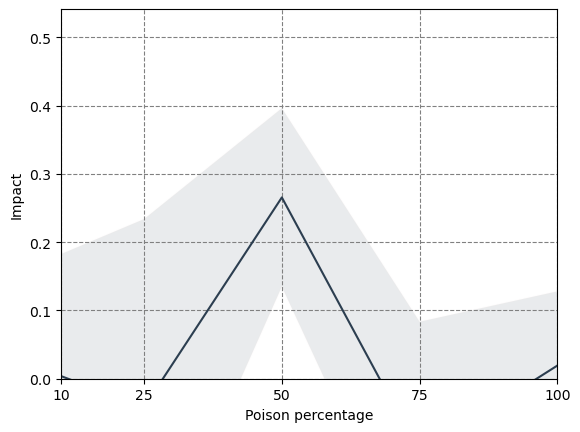

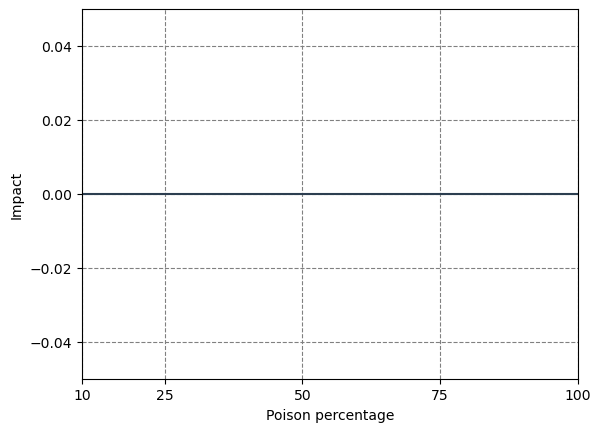

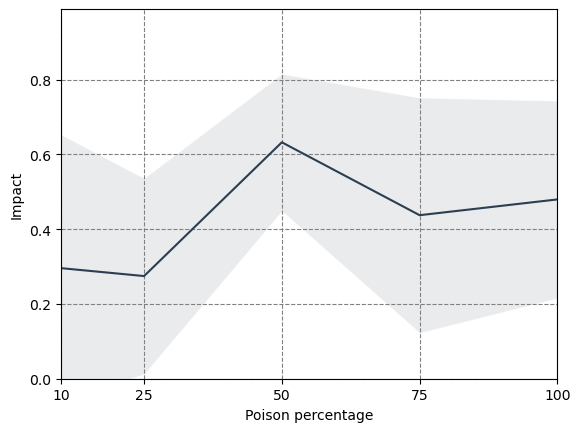

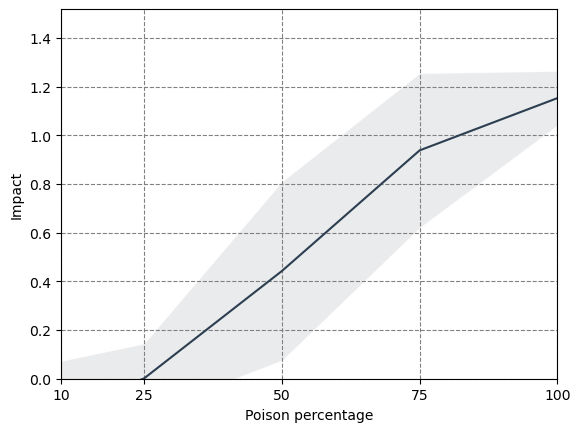

In [93]:
avg_new=np.average(np.array(impacts_new), axis=0)
stdev_new=np.std(np.array(impacts_new), axis=0)
complexity_new_avg = np.average(np.array(complexity_new), axis=0)
complexity_new_st = np.std(np.array(complexity_new), axis=0)

avg_ext=np.average(np.array(impacts_exist), axis=0)
stdev_ext=np.std(np.array(impacts_exist), axis=0)
complexity_ext_avg = np.average(np.array(complexity_exist), axis=0)
complexity_ext_st = np.std(np.array(complexity_exist), axis=0)

avg_new=np.average(np.array(impacts_new), axis=0)
stdev_new=np.std(np.array(impacts_new), axis=0)
complexity_new_avg = np.average(np.array(complexity_new), axis=0)
complexity_new_st = np.std(np.array(complexity_new), axis=0)

avg_swap=np.average(np.array(impacts_swap), axis=0)
stdev_swap=np.std(np.array(impacts_swap), axis=0)
complexity_swap_avg = np.average(np.array(complexity_swap), axis=0)
complexity_swap_st = np.std(np.array(complexity_swap), axis=0)

avg_target=np.average(np.array(impacts_target), axis=0)
stdev_target=np.std(np.array(impacts_target), axis=0)
complexity_target_avg = np.average(np.array(complexity_target), axis=0)
complexity_target_st = np.std(np.array(complexity_target), axis=0)

draw_graph(x=[10,25,50,75,100], y_list = [avg_new], 
           err_list = [stdev_new], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_new)+max(stdev_new)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

draw_graph(x=[10,25,50,75,100], y_list = [avg_ext], 
           err_list = [stdev_ext], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_ext)+max(stdev_ext)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

draw_graph(x=[10,25,50,75,100], y_list = [avg_swap], 
           err_list = [stdev_swap], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

draw_graph(x=[10,25,50,75,100], y_list = [avg_target], 
           err_list = [stdev_target], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_target)+max(stdev_target)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)


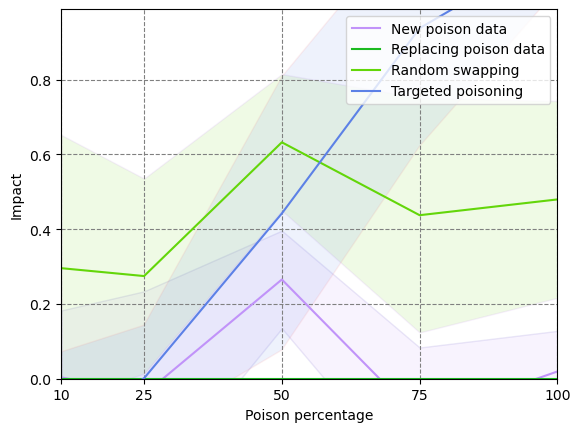

In [94]:
draw_graph(x=[10,25,50,75,100], y_list = [avg_new, avg_ext, avg_swap, avg_target], 
           err_list = [stdev_new, stdev_ext, stdev_swap,stdev_target], label_list=['New poison data','Replacing poison data','Random swapping','Targeted poisoning'],
            xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
           is_legend=True, alpha=0.1, thresh_on=False)

## XAI Metrics

In [149]:
# Load the test dataset from csv files
full_dataset = pd.read_csv("../../output_full_web_or_not.csv", header=0, usecols=[*range(1,23)], sep=";") 
full_dataset.dropna(axis = 0, inplace = True)
print("The shape of the full dataset: " + str(full_dataset.shape))

full_dataset.head()

# Set of features in the dataset
features = list(full_dataset.columns)
print("Features: " + str(features[:-1]))

y_df = full_dataset['output'].to_frame()
X_df = full_dataset[full_dataset.columns.difference(['output'])]

X_eval_w_or_n, X_test_w_or_n, y_eval_w_or_n, y_test_w_or_n = train_test_split(X_df, y_df, train_size=0.7, random_state=1)

scaler = StandardScaler()
scaler.fit(X_eval_w_or_n)
X_eval_=X_eval_w_or_n.reset_index().iloc[:, 1:]
X_test_=X_test_w_or_n.reset_index().iloc[:, 1:]

# Apply transform to both the training/testing dataset.
X_eval_w_or_n = pd.DataFrame(scaler.transform(X_eval_),columns=X_eval_w_or_n.columns,index=X_eval_w_or_n.index)
X_test_w_or_n = pd.DataFrame(scaler.transform(X_test_),columns=X_eval_w_or_n.columns,index=X_test_w_or_n.index)

print("Shape of the eval dataset: " + str(X_eval_w_or_n.shape) + ", " + str(y_train_w_or_n.shape))
print("Shape of the testing dataset: " + str(X_eval_w_or_n.shape) + ", " + str(y_test_w_or_n.shape))

print(y_eval_w_or_n.index.tolist())

The shape of the full dataset: (382, 22)
Features: ['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']
Shape of the eval dataset: (267, 21), (267, 1)
Shape of the testing dataset: (267, 21), (115, 1)
[85, 58, 355, 231, 249, 171, 274, 131, 349, 325, 279, 210, 80, 88, 124, 229, 14, 253, 123, 111, 51, 112, 9, 221, 16, 322, 0, 105, 172, 235, 70, 38, 150, 225, 369, 145, 42, 313, 175, 207, 180, 383, 278, 176, 147, 257, 100, 34, 110, 334, 135, 365, 154, 19, 314, 158, 267, 44, 265, 254, 237, 108, 337, 169, 79, 370, 305, 8, 195, 99, 340, 321, 312, 28, 31, 55, 356, 32, 268, 48, 357, 275, 33, 374, 35, 361, 63, 157, 128, 46, 66, 378, 328, 245, 371, 381, 341, 45, 212, 168, 241, 47, 113, 178, 226, 297, 40, 21, 101,

In [156]:
X_eval_w_or_n

,%dl_volume,%tcp_protocol,%udp_protocol,%ul_volume,avg_dl_volume,avg_ul_volume,dl_data_volume,dl_packet,kB/s,max_dl_volume,...,min_dl_volume,min_ul_volume,nb_downlink_packet,nb_packet/s,nb_uplink_packet,session_time,std_dl_volume,std_ul_volume,ul_data_volume,ul_packet
85,0.403104,0.615370,-0.612251,-0.403104,-0.240089,-0.558769,0.180124,0.084115,-0.322516,-0.408791,...,-0.123289,-0.413045,0.271941,-0.307798,0.488210,1.280890,-0.567786,-0.589657,0.288277,-0.084115
58,0.418463,0.620666,-0.617576,-0.418463,-0.231359,-0.569353,2.023199,0.312396,0.416422,-0.100143,...,-0.123289,-0.413045,2.285339,1.029062,2.439082,1.272477,-0.458367,-0.660284,2.011615,-0.312396
355,0.431649,-1.644241,1.659767,-0.431649,-0.390991,0.184505,-0.267947,1.876464,-0.281545,-0.717439,...,-0.123289,-0.413045,-0.097530,-0.320397,-0.535048,-0.125258,-0.668761,0.397265,-0.420723,-1.876464
231,0.334996,0.612216,-0.609079,-0.334996,-0.435029,-0.564711,-0.319343,-0.325603,-0.133220,-0.299426,...,-0.123289,-0.413045,-0.124126,0.595737,0.211760,-0.510609,-0.492492,-0.629305,0.027231,0.325603
249,0.311379,0.609905,-0.606756,-0.311379,-0.430939,-0.558180,-0.516455,-0.554080,-0.061412,-0.150598,...,-0.123289,-0.413045,-0.423871,0.901376,-0.182607,-0.924912,-0.454144,-0.587828,-0.322638,0.554080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,-3.242138,-1.853338,1.870012,3.242138,-0.912807,5.124721,-0.719046,-1.189008,-0.658955,-0.778323,...,0.059481,3.508960,-0.717866,-0.912996,-0.690960,-1.012418,-0.690848,4.275761,-0.529956,1.189008
262,0.336940,0.518660,-0.515010,-0.336940,-0.332944,-0.384284,-0.688829,-0.114601,-0.630455,-0.305909,...,-0.123289,-0.413045,-0.689114,-0.900265,-0.664757,-0.658229,-0.311699,-0.172650,-0.747244,0.114601
72,0.429684,0.621791,-0.618707,-0.429684,-0.232571,-0.575739,2.610522,0.524954,1.138497,0.105622,...,-0.123289,-0.413045,2.936584,2.233269,2.632990,0.589596,-0.482350,-0.775390,2.149878,-0.524954
242,0.310524,0.609819,-0.606670,-0.310524,-0.433513,-0.558051,-0.518841,-0.553631,-0.132412,-0.299426,...,-0.123289,-0.413045,-0.426028,0.688994,-0.186538,-0.885356,-0.499283,-0.587139,-0.326111,0.553631


In [157]:
epochs=150
model_type='random_forest' # 'random_forest' or 'lightgbm'

model_ori, model_poison = get_models_for_attack(epochs=epochs, verbose=0,model_type=model_type)

X_train_new, Y_train_new,_,_ = get_poison_set(X_train, Y_train, X_poison, Y_poison, poison_type='random_swapping', percentage=50)
Y_trans = np.array(list(map((lambda x: 1 if x<1 else 2),np.argmax(Y_train_new,axis=1))))

model_poison.fit(X_train_new, Y_trans)
xpl = SmartExplainer(
    #preprocessing=encoder,
    model=model_poison,
    backend='shap',
    #data=X_train,     # Here we pass this optional parameter that is used by ACV
)
xpl.compile(x=X_eval_w_or_n,
y_target=y_eval_w_or_n, # Optional: allows to display True Values vs Predicted Values
)

True


In [ ]:
# Y_trans = np.array(list(map((lambda x: 1 if x<1 else 2),np.argmax(Y_train_new,axis=1))))

In [159]:
xpl.plot.features_importance()

In [160]:
xpl.plot.contribution_plot(col='%dl_volume')

In [153]:
app = xpl.run_app(title_story='User Network Activities Classification', port=8020)

Dash is running on http://0.0.0.0:8020/



INFO:root:Your Shapash application run on http://CHAMARA-XPS:8020/
INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8020/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8020/



 * Serving Flask app 'shapash.webapp.smart_app'


 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8020
 * Running on http://192.168.2.99:8020
INFO:werkzeug:Press CTRL+C to quit


In [161]:
app.kill()

In [167]:
# poison_df = pd.DataFrame(X_train_new[:10],columns=X_eval_w_or_n.columns)
# from shapash.explainer.consistency import Consistency
# cns = Consistency()
# cns.compile(x=poison_df, # Dataset for which we need explanations
#             model=model_cp, # Model to explain
#             #preprocessing=encoder, # Optional
#             )

In [ ]:
# cns.consistency_plot(max_features=21)

In [ ]:
# # index = X_test.index.tolist() -> error index out of bound ?
# index = [1, 2, 3, 4, 5]
# cns.consistency_plot(selection=index, max_features=21)

In [188]:
import shap

treeSHAP = shap.TreeExplainer(model_poison).shap_values(X_eval_w_or_n[:50], check_additivity=False)[1]
samplingSHAP = shap.SamplingExplainer(model_poison.predict_proba, shap.kmeans(X_eval_w_or_n[:50], 5)).shap_values(X_eval_w_or_n[:50], check_additivity=False)[1]
kernelSHAP = shap.KernelExplainer(model_poison.predict_proba, shap.kmeans(X_eval_w_or_n[:50], 5)).shap_values(X_eval_w_or_n[:50], check_additivity=False)[1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00554724  0.01670343  0.02266862  0.00115035 -0.01775845  0.00314699
 -0.09696065  0.00086721  0.00459468  0.01328233  0.00199145 -0.00033435
  0.00699369 -0.00827302 -0.00716882  0.00584308 -0.02931655 -0.01866954
  0.00111299 -0.01183198  0.00373879]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00554724 -0.01670343 -0.02266862 -0.00115035  0.01775845 -0.00314699
  0.09696065 -0.00086721 -0.00459468 -0.01328233 -0.00199145  0.00033435
 -0.00699369  0.00827302  0.00716882 -0.00584308  0.02931655  0.01866954
 -0.00111299  0.01183198 -0.00373879]
INFO:shap:num_full_subsets = 2
INFO:s

In [170]:
treeSHAP = shap.TreeExplainer(model_poison).shap_values(X_eval_w_or_n[:5], check_additivity=False)[1]

In [ ]:
len(full_dataset.columns[:-1])

In [189]:
treeSHAP = pd.DataFrame(treeSHAP, columns=full_dataset.columns[:-1])
samplingSHAP = pd.DataFrame(samplingSHAP, columns=full_dataset.columns[:-1])
kernelSHAP = pd.DataFrame(kernelSHAP, columns=full_dataset.columns[:-1])

In [183]:
kernelSHAP

,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,min_dl_volume,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s
0,0.004430,-0.009950,-0.015487,0.004836,0.004659,-0.002518,0.100752,-0.004770,-0.006466,-0.014484,...,0.000000,-0.002463,0.000532,0.007388,-0.003984,0.017201,0.005955,-0.000737,-0.027705,-0.008873
1,0.003837,-0.009448,-0.011377,0.004027,0.002936,-0.001736,0.068311,-0.000404,0.004419,-0.005229,...,0.000189,-0.000357,0.009204,-0.002421,0.035162,0.011173,0.004093,0.004672,0.007076,-0.010181
2,0.001754,0.050392,0.057973,-0.004060,0.007407,0.017298,-0.004410,0.006735,-0.003875,-0.014041,...,0.000000,0.000924,0.000605,0.000301,0.000633,-0.007108,0.027149,0.000447,-0.015439,0.083798
3,-0.006553,-0.009749,-0.018174,0.004915,0.004195,-0.001729,0.001281,0.001594,-0.003330,-0.008860,...,0.000000,-0.002200,-0.003266,0.005861,-0.002911,-0.001014,0.004641,-0.000656,-0.032008,-0.014247
4,-0.007691,-0.010448,-0.018074,-0.000803,0.002847,-0.001852,-0.024959,-0.006734,-0.002152,-0.004453,...,0.000337,-0.001602,-0.003494,0.003628,-0.008511,0.006951,0.004217,-0.003089,-0.042889,-0.014626
5,-0.002549,-0.004956,-0.008470,-0.002476,-0.015812,0.014738,-0.026081,0.006210,0.022334,-0.014076,...,-0.001660,0.017374,0.025323,0.007476,-0.012545,0.003266,0.001151,0.001863,0.071329,-0.008905
6,0.001340,-0.006964,-0.009272,0.001733,0.003844,-0.003211,-0.002345,0.009026,0.000543,0.046135,...,0.000398,-0.000358,-0.014205,-0.000830,-0.003837,0.005474,-0.022240,-0.004763,-0.038214,-0.014360
7,-0.004639,0.007003,0.030934,-0.000375,-0.007694,0.024973,-0.024192,-0.003752,-0.002393,0.000745,...,0.000403,-0.000960,0.003708,0.003935,-0.005569,0.002442,-0.014616,0.001199,0.063577,-0.004568
8,-0.002544,0.081554,0.047778,-0.001196,-0.000450,0.019488,-0.019166,0.004349,0.018640,0.010705,...,0.000172,0.013226,-0.007598,0.003679,-0.003605,0.017264,0.003225,0.017397,-0.009501,-0.006708
9,0.006009,-0.011704,-0.005352,0.002650,-0.011530,-0.003563,-0.024305,-0.004732,-0.007195,0.036688,...,0.000368,-0.000493,-0.007650,0.002257,-0.004765,0.007751,-0.024476,-0.005309,-0.035273,-0.013423


In [184]:
treeSHAP

,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,min_dl_volume,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s
0,0.021131,-0.021577,-0.022365,-0.001424,0.011164,-0.000511,0.080527,0.006381,-0.003060,-0.009315,...,0.001823,-0.006870,-0.001763,0.025174,-0.004723,0.017150,0.011484,0.008983,-0.005097,-0.000258
1,0.022132,-0.020766,-0.013673,-0.000285,0.012610,-0.000736,0.055309,0.013970,0.007677,0.000871,...,0.002569,0.004598,0.008717,0.006489,0.023626,0.016992,0.003755,0.011475,0.020850,-0.003489
2,0.019568,0.041285,0.050002,-0.009278,0.027183,0.012226,-0.006798,0.012460,0.002050,-0.007563,...,0.002094,0.000133,0.001409,0.014327,-0.003657,-0.005243,0.033179,0.010733,0.000380,0.068464
3,0.009160,-0.021290,-0.023368,-0.002156,0.018777,-0.000672,-0.003544,0.015252,0.002500,-0.003221,...,0.002636,-0.009819,-0.003499,0.016537,-0.005693,-0.001557,0.003665,0.006451,-0.015617,-0.007101
4,0.005135,-0.019429,-0.023607,-0.004830,0.017023,-0.002861,-0.027041,0.005836,0.005167,-0.003818,...,0.002634,-0.006148,-0.001853,0.017953,-0.011309,0.006882,0.004486,0.001665,-0.025384,-0.010354
5,0.011919,-0.017959,-0.008203,0.001826,-0.008877,0.011281,-0.032954,0.017278,0.026551,-0.002469,...,0.002982,0.006214,0.018281,0.036059,-0.010028,-0.000565,0.005965,0.014897,0.061102,-0.007341
6,0.009489,-0.015636,-0.013972,-0.005958,0.021006,-0.000685,-0.004367,0.020251,0.003438,0.037724,...,0.001967,-0.001913,-0.010891,0.011849,-0.006205,0.006632,-0.007804,-0.002738,-0.024641,-0.011085
7,0.012012,0.000647,0.019373,-0.005688,0.007561,0.016600,-0.030158,0.003942,0.003945,0.010955,...,0.007001,0.000074,0.008858,0.021169,-0.014699,0.007592,-0.001869,0.016578,0.055394,-0.000443
8,0.008523,0.065960,0.045283,0.000994,0.014702,0.013276,-0.021599,0.016773,0.018698,0.013882,...,0.000792,0.005622,-0.005278,0.019195,-0.002692,0.015688,0.008848,0.023085,0.005507,-0.005346
9,0.019039,-0.017789,-0.012006,-0.007711,0.002934,-0.003894,-0.027462,0.007020,-0.001770,0.030488,...,0.001982,-0.001704,-0.007808,0.017923,-0.012128,0.008777,-0.006457,-0.004393,-0.017238,-0.009193


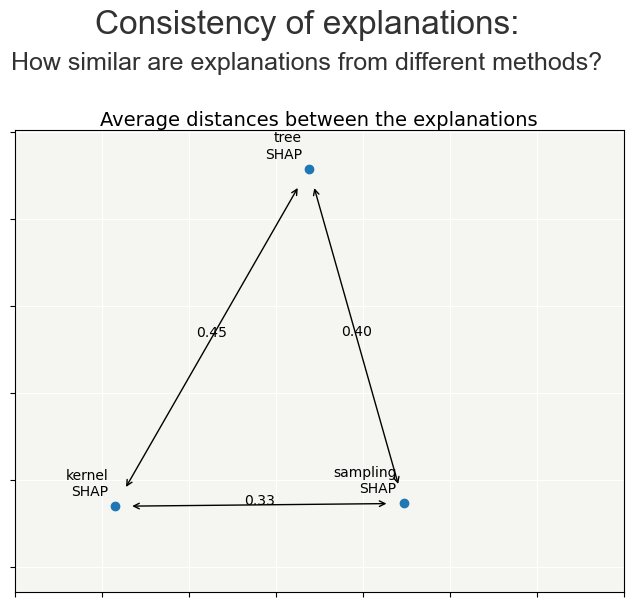

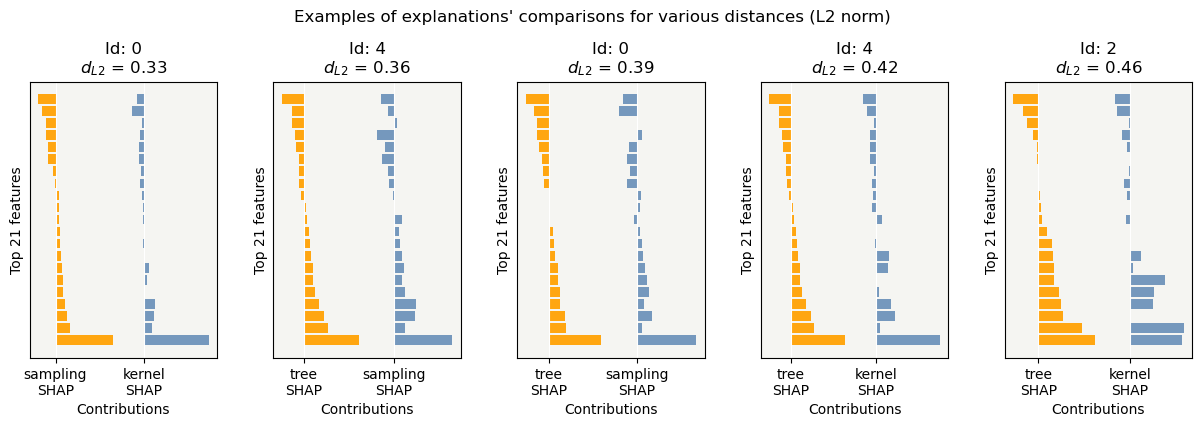

In [195]:
# The format must be a dictionary where keys are methods names and values are pandas DataFrames: be careful to have dataframes with same shape, index and column names
# contributions = { "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}
contributions = {"tree\nSHAP": treeSHAP,  "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}

index = [45, 36, 12, 17, 29]
cns = Consistency()
cns.compile(contributions=contributions,
            x=X_eval_w_or_n[:50] #Optionnal, needed to display pairwise_consistency_plot
           )
cns.consistency_plot(selection=index, max_features=21)

In [197]:
response_dict = {1: 'Web', 2: 'Not Web'}

features = list(full_dataset.columns)
features_dict = dict(zip(features, features))
xpl = SmartExplainer(
    model=model_poison, 
    #preprocessing=encoder, 
    features_dict=features_dict, # Optional parameters
    label_dict=response_dict    # Optional parameters, dicts specify labels 
)
xpl.compile(x=X_eval_w_or_n) # X_eval_w_or_n is the sample 
xpl.plot.compacity_plot()

In [198]:
xpl.plot.stability_plot()

In [199]:
index = [1, 2, 3, 8, 9]

# Using distribution = "boxplot" or "violin" displays distributions of variability instead of means
xpl.plot.stability_plot(selection=index, max_features=5, distribution="boxplot")

In [200]:
xpl.plot.local_neighbors_plot(index=1)

In [217]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Not Web']
explainer = shap.KernelExplainer(model_poison.predict, X_eval_w_or_n)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_eval_w_or_n, nsamples=50)
#print(shap_values)

  0%|          | 0/267 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.29184991 0.15360522 0.10809256 0.08583821 0.07296248 0.06485554
 0.05956121 0.05612498 0.05404628 0.05306362]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 1.0000000000000002
INFO:shap:np.sum(w_aug) = 21.000000000000004
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.01518226 -0.02601477 -0.02537284 -0.00798868  0.00944154 -0.01221319
  0.          0.01605127 -0.0069927  -0.01349294  0.00237351  0.00961733
 -0.009244    0.          0.02313739  0.00061841  0.01786505  0.
 -0.01165561 -0.00797182 -0.02162737]
INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.29184991 0.15360522 0.10809256 0.08583821 0.07296248 0.06485554
 0.05956121 0.05612498 0.05404628 0.05306362]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 1.0000000000000002
INFO:shap:np.sum(w_aug) = 21.000000000000007
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:

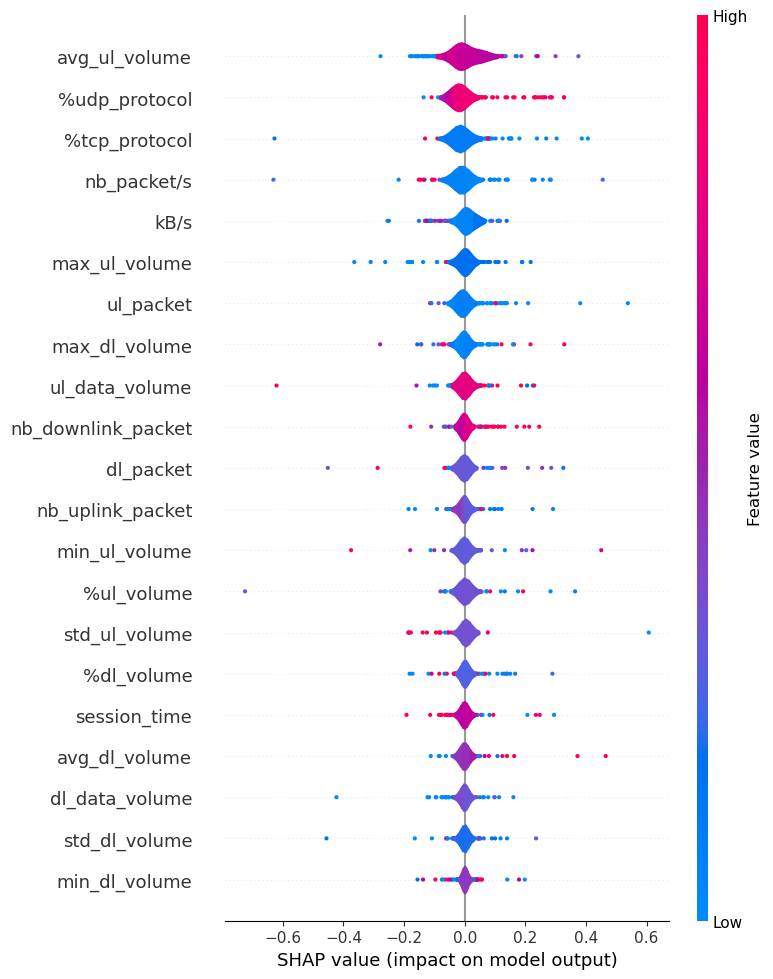

In [218]:
shap.summary_plot(shap_values, X_eval_w_or_n, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value', plot_type="violin")
# shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
# shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

# shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
#                     class_names=classes, color_bar_label='Feature value for all')